In [1]:
import ipywidgets as widgets
from IPython.display import display
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import spectrogram_plot_2024_func
from signal_api import butter_highpass_filter, butter_lowpass_filter
import glob
import os

with open('defaults.yaml', "r") as f:
    default_configs = yaml.safe_load(f)


# File chooser for CSV files
# Get all CSV files from ../data folder
csv_files = glob.glob(os.path.join('../data', '*.csv'))

file_chooser = widgets.Dropdown(
    options=csv_files,
    description='CSV File:',
    layout=widgets.Layout(width='50%')
)
data_folder_label = widgets.Label(value="Please select a CSV file from the '../data' folder.")

# LowPass and HighPass checkboxes
lowpass_checkbox = widgets.Checkbox(
    value=default_configs['LowPass']['enabled'],
    description='LowPass'
)
highpass_checkbox = widgets.Checkbox(
    value=default_configs['HighPass']['enabled'],
    description='HighPass'
)

# LowPass and HighPass numerical inputs
highpass_num = widgets.FloatText(
    value=default_configs['HighPass']['cutoff_frequency'],
    description='HighPass (Hz)'
)

lowpass_num = widgets.FloatText(
    value=default_configs['LowPass']['cutoff_frequency'],
    description='LowPass (Hz)'
)


# Window denoise tickbox
window_denoise_checkbox = widgets.Checkbox(
    value=default_configs['WindowDenoise']['enabled'],
    description='Window Denoise'
)
window_denoise_num = widgets.FloatText(
    value=default_configs['WindowDenoise']['threshold'],
    description='Threshold'
)

# PGA gain numerical inputs
pga_gain_label = widgets.Label(value="PGA Gain")
pga_gain_inputs = [
    widgets.FloatText(value=default_configs['PGA'][f'Ch{i+1}'], description=f'Ch{i+1}', layout=widgets.Layout(width='150px'))
    for i in range(5)
]
pga_gain_box = widgets.VBox([
    pga_gain_label,
    widgets.HBox(pga_gain_inputs, layout=widgets.Layout(width='100%'))
])

# Layout
ui = widgets.VBox([
    file_chooser,
    widgets.HBox([highpass_checkbox, highpass_num]),
    widgets.HBox([lowpass_checkbox, lowpass_num]),
    widgets.HBox([window_denoise_checkbox, window_denoise_num]),
    widgets.HBox(pga_gain_inputs)
])

display(ui)

In [4]:
from helpers import spectrogram_plot_2024_func, window_median_denoise, impute_with_left

fs = 80.0
data = pd.read_csv(file_chooser.value)

all_spectrograms = []

for col_idx in range(data.shape[1]):
    col_data = data.iloc[:, col_idx].to_numpy()
    col_data, nan_mask = impute_with_left(col_data)
    print(f"Column {col_idx}: {len(nan_mask)} NaNs were imputed with left values.")

    if highpass_checkbox.value:  
        col_data = butter_highpass_filter(col_data, highpass_num.value, int(fs))
    if lowpass_checkbox.value:
        col_data = butter_lowpass_filter(col_data, lowpass_num.value, int(fs))

    sepctrogram_data, _ = spectrogram_plot_2024_func(col_data)

    if window_denoise_checkbox.value:
        sepctrogram_data, denoise_mask = window_median_denoise(sepctrogram_data, fs)
        print(f"Column {col_idx}: {len(denoise_mask)} windows were denoised.")

    all_spectrograms.append(sepctrogram_data)


Column 0: 0 NaNs were imputed with left values.
Column 0: 0 windows were denoised.
Column 1: 0 NaNs were imputed with left values.
Column 1: 0 windows were denoised.
Column 2: 0 NaNs were imputed with left values.
Column 2: 0 windows were denoised.
Column 3: 0 NaNs were imputed with left values.
Column 3: 0 windows were denoised.
Column 4: 0 NaNs were imputed with left values.
Column 4: 0 windows were denoised.
Column 5: 0 NaNs were imputed with left values.
Column 5: 1 windows were denoised.
Column 6: 0 NaNs were imputed with left values.
Column 6: 1 windows were denoised.
Column 7: 0 NaNs were imputed with left values.
Column 7: 0 windows were denoised.
Column 8: 0 NaNs were imputed with left values.
Column 8: 2 windows were denoised.
Column 9: 0 NaNs were imputed with left values.
Column 9: 0 windows were denoised.
Column 10: 14260 NaNs were imputed with left values.
Column 10: 1 windows were denoised.
Column 11: 14260 NaNs were imputed with left values.
Column 11: 0 windows were de

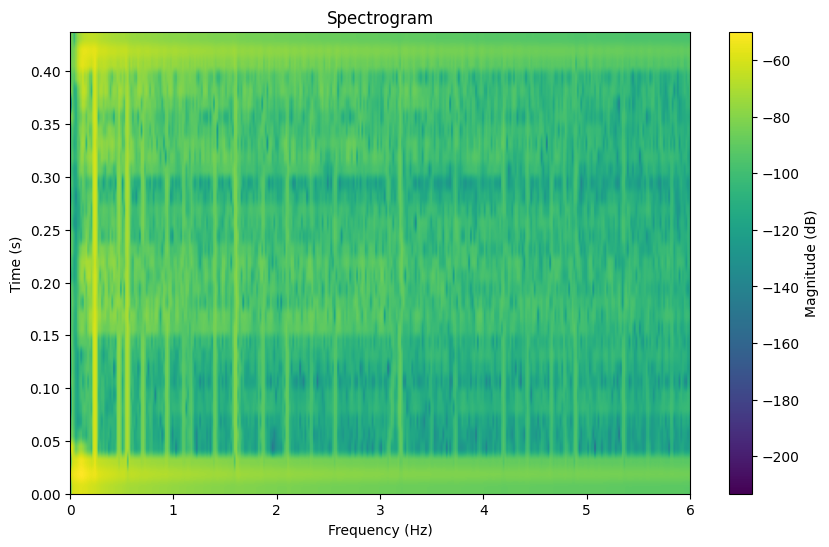

In [6]:
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(np.abs(all_spectrograms[0])),  aspect='auto', origin='lower', extent=(0., fs/2, 0., all_spectrograms[0].shape[0]/fs), cmap='viridis')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Time (s)')
plt.title('Spectrogram')
plt.colorbar(label='Magnitude (dB)')
plt.xlim(0, 6)
plt.show()

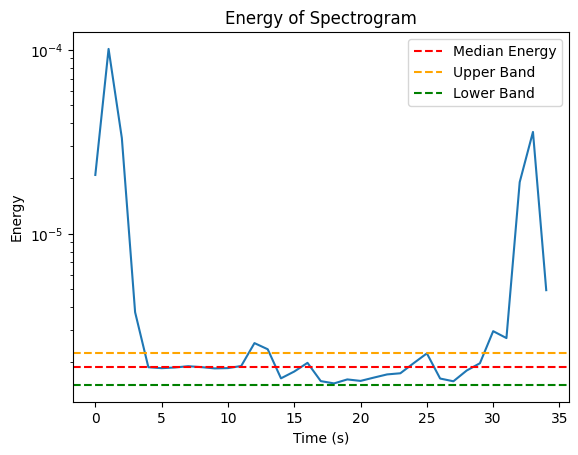

In [10]:
energy = np.sum(np.abs(all_spectrograms[0])**2, axis=1)
median_energy = np.median(energy)
upper_median_band = median_energy * (1 + window_denoise_num.value)
lower_median_band = median_energy * (1 - window_denoise_num.value)

plt.plot(energy)
plt.axhline(median_energy, color='red', linestyle='--', label='Median Energy')
plt.axhline(upper_median_band, color='orange', linestyle='--', label='Upper Band')
plt.axhline(lower_median_band, color='green', linestyle='--', label='Lower Band')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.yscale('log')
plt.title('Energy of Spectrogram')
plt.legend()